In [4]:
# Hotel Guest Satisfaction Driver Analysis

## Business Question
# Which operational service factors most strongly drive overall guest satisfaction, and do these drivers differ between high- and low-satisfaction guests?

## Background
# Hotels collect detailed post-stay surveys, but not all service attributes contribute equally to overall satisfaction. This project builds a data-driven model to quantify driver impact and support operational prioritization.

In [8]:
# Core libraries
import pandas as pd
import numpy as np

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Load dataset
df = pd.read_csv("data/hotel_survey_synthetic.csv")

# Basic sanity check
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5000, 24)


,response_id,property_id,stay_date_weekday,season,purpose,channel,loyalty_tier,room_type,stay_nights,lead_time_days,rate_usd,issue_reported,cleanliness_score,staff_friendliness_score,checkin_score,room_comfort_score,value_for_money_score,wifi_score,breakfast_score,noise_level_score,problem_resolution_score,overall_satisfaction_score,likelihood_to_recommend,comment_text
0,R000001,H002,Sun,Summer,Leisure,Direct,Gold,Standard,3,19,147.16,0,6,6,9,6,5,8,7,10,9,7,6,great service from the team; could be better
1,R000002,H007,Sun,Fall,Business,OTA,Gold,Standard,6,15,175.62,0,6,4,4,4,8,8,8,6,6,6,6,issue was resolved quickly; okay overall
2,R000003,H015,Sat,Winter,Leisure,Corporate,NaN,Standard,5,7,80.00,0,3,4,5,4,3,4,5,3,1,4,4,great view from the room; fees felt high; won’...
3,R000004,H009,Thu,Spring,Leisure,Direct,NaN,Premium,7,20,236.78,0,3,4,4,3,2,8,3,5,4,4,4,fees felt high; won’t be back
4,R000005,H004,Thu,Summer,Business,Direct,NaN,Standard,2,17,291.81,0,3,4,3,1,3,3,2,2,1,2,1,good value; needs improvement


In [9]:
# Quick overview
df.info()

# Missing value check
missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0]

#Score distribution sanity check
score_cols = [
    "cleanliness_score",
    "staff_friendliness_score",
    "checkin_score",
    "room_comfort_score",
    "value_for_money_score",
    "wifi_score",
    "breakfast_score",
    "problem_resolution_score",
    "overall_satisfaction_score"
]

df[score_cols].describe().round(2)

#correlation

corr = df[score_cols].corr()

corr["overall_satisfaction_score"].sort_values(ascending=False)

## Initial EDA Observations
# Survey attributes are numeric and on a consistent 1–10 scale
# Overall satisfaction shows meaningful variation suitable for regression modeling
# Cleanliness, staff friendliness, and problem resolution show strong correlations with overall satisfaction
# No major data quality issues observed at a high level


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   response_id                 5000 non-null   object 
 1   property_id                 5000 non-null   object 
 2   stay_date_weekday           5000 non-null   object 
 3   season                      5000 non-null   object 
 4   purpose                     5000 non-null   object 
 5   channel                     5000 non-null   object 
 6   loyalty_tier                2762 non-null   object 
 7   room_type                   5000 non-null   object 
 8   stay_nights                 5000 non-null   int64  
 9   lead_time_days              5000 non-null   int64  
 10  rate_usd                    5000 non-null   float64
 11  issue_reported              5000 non-null   int64  
 12  cleanliness_score           5000 non-null   int64  
 13  staff_friendliness_score    5000 

overall_satisfaction_score    1.000000
cleanliness_score             0.813973
room_comfort_score            0.778393
staff_friendliness_score      0.773314
checkin_score                 0.732090
value_for_money_score         0.721210
wifi_score                    0.678994
problem_resolution_score      0.676358
breakfast_score               0.661236
Name: overall_satisfaction_score, dtype: float64

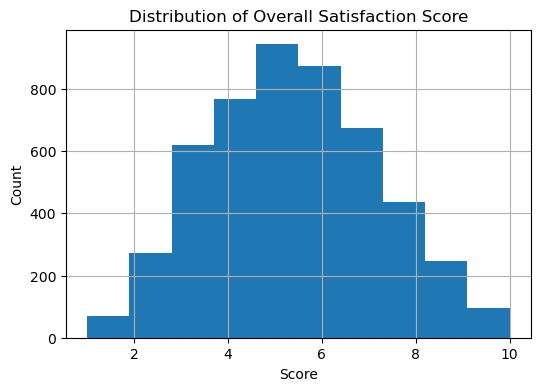

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df["overall_satisfaction_score"].hist(bins=10)
plt.title("Distribution of Overall Satisfaction Score")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

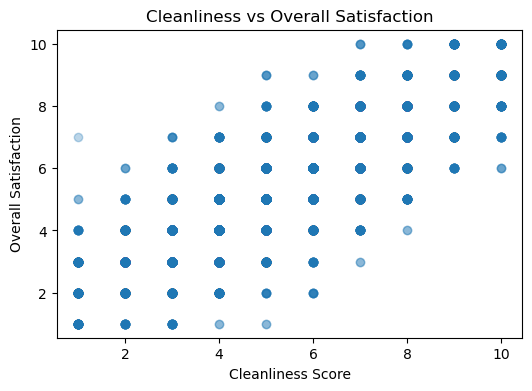

In [11]:
plt.figure(figsize=(6,4))
plt.scatter(df["cleanliness_score"], df["overall_satisfaction_score"], alpha=0.3)
plt.title("Cleanliness vs Overall Satisfaction")
plt.xlabel("Cleanliness Score")
plt.ylabel("Overall Satisfaction")
plt.show()

In [12]:
## Feature Selection and Modeling Setup

# The modeling goal is to quantify how individual service attributes contribute to overall guest satisfaction.

# To maintain interpretability and align with common hospitality
# driver analysis practices, the initial model focuses on
# core service attribute scores as predictors.

# Target variable
target = "overall_satisfaction_score"

# Core service attribute features
features = [
    "cleanliness_score",
    "staff_friendliness_score",
    "checkin_score",
    "room_comfort_score",
    "value_for_money_score",
    "wifi_score",
    "breakfast_score",
    "problem_resolution_score"
]

X = df[features]
y = df[target]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (5000, 8)
Target shape: (5000,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

### Notes
# Feature set is restricted to core service attributes to maximize interpretability
# Guest segmentation and interaction effects will be explored in later analysis
# A hold-out test set is used to evaluate generalization performance

Training set size: (4000, 8)
Test set size: (1000, 8)


In [15]:
## Baseline Model: Linear Regression

# Linear regression is used as a baseline model to quantify the direction and magnitude of 
# impact each service attribute has
# on overall guest satisfaction.

# This approach prioritizes interpretability and aligns with
# traditional driver analysis used in hospitality analytics.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize the model
lr = LinearRegression()

# Train (fit) the model on training data
lr.fit(X_train, y_train)

# Predict on test data (unseen during training)
y_pred = lr.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.3f}")

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df

Mean Absolute Error (MAE): 0.55
R-squared (R²): 0.879


,Feature,Coefficient
0,cleanliness_score,0.238184
1,staff_friendliness_score,0.181962
3,room_comfort_score,0.148419
7,problem_resolution_score,0.135439
4,value_for_money_score,0.133747
2,checkin_score,0.099184
5,wifi_score,0.050864
6,breakfast_score,0.043132


In [16]:
## Machine Learning Model: Random Forest Regressor

# While linear regression provides interpretable driver weights, it assumes
# linear and additive relationships between service attributes and satisfaction.

# A Random Forest model is introduced to capture potential non-linear effects
# and interaction patterns between service attributes, without explicitly
# specifying the functional form.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# random forest model
rf.fit(X_train, y_train)

#predict and evaluate
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.3f}")

rf_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

rf_importance

Random Forest MAE: 0.56
Random Forest R²: 0.867


,Feature,Importance
0,cleanliness_score,0.532065
3,room_comfort_score,0.157881
1,staff_friendliness_score,0.122488
7,problem_resolution_score,0.060217
4,value_for_money_score,0.047309
2,checkin_score,0.033594
5,wifi_score,0.023785
6,breakfast_score,0.022663


0.50.0


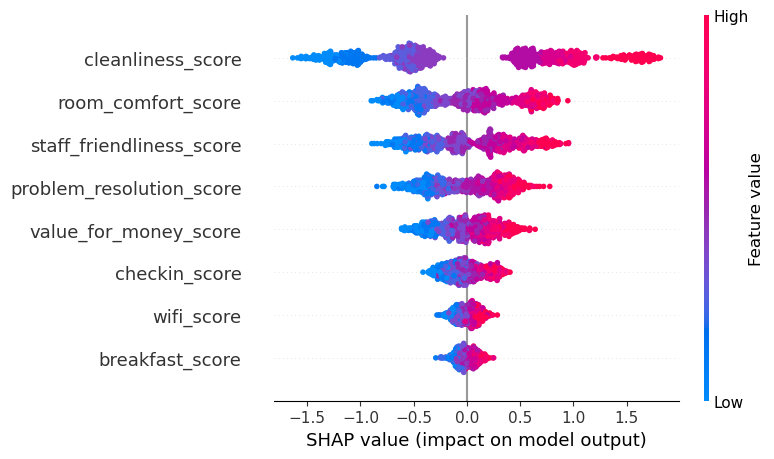

In [18]:
import shap

print(shap.__version__)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [19]:
# Define satisfaction segments
low_mask = y_test <= 6
high_mask = y_test >= 9

X_low = X_test[low_mask]
X_high = X_test[high_mask]

print("Low satisfaction samples:", X_low.shape[0])
print("High satisfaction samples:", X_high.shape[0])

Low satisfaction samples: 707
High satisfaction samples: 72


In [20]:
shap_low = explainer.shap_values(X_low)
shap_high = explainer.shap_values(X_high)

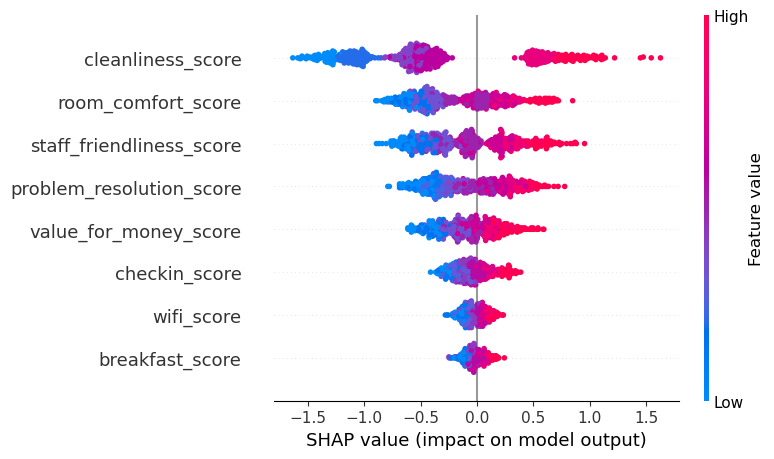

In [21]:
shap.summary_plot(shap_low, X_low, show=False)

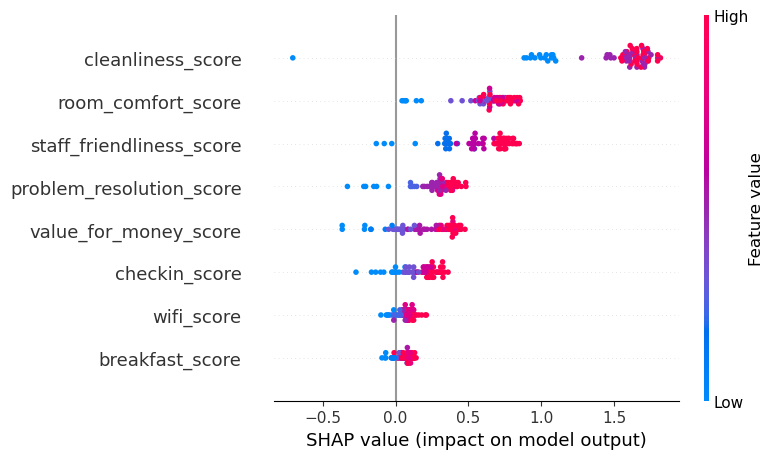

In [22]:
shap.summary_plot(shap_high, X_high, show=False)